<a href="https://colab.research.google.com/github/Guilherme1258/Maze-IA/blob/main/Detec%C3%A7%C3%A3o%20de%20linguagem%20ofensiva%20PLN_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando as bibliotecas e preparando o ambiente

importando as bibliotecas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

from transformers import AutoModel, AutoTokenizer, AutoModelForPreTraining, TFAutoModelForSequenceClassification
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, Trainer, TrainingArguments

from tensorflow.keras.optimizers.legacy import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Carregando as bases de dados "*HateBR*" e "*Brazilian Portuguese Hatespeech dataset*"

In [ ]:
data_hateBR = pd.read_csv("/content/drive/MyDrive/HateBR.csv")

data_hatespeech = pd.read_csv("/content/drive/MyDrive/2019-05-28_portuguese_hate_speech_binary_classification.csv")

mostrando as primeiras linhas de cada DataFrame

In [ ]:
data_hateBR.head()

,instagram_comments,offensive_language,offensiveness_levels,hate_speech
0,este lixo ...,1,1,-1
1,Mais um lixo,1,1,-1
2,Essa nao tem vergonha na cara!!,1,2,-1
3,Essa mulher é doente.pilantra!,1,3,-1
4,Comunista safada...,1,2,"5,8"


In [ ]:
data_hatespeech.head()

,text,hatespeech_comb,hatespeech_G1,annotator_G1,hatespeech_G2,annotator_G2,hatespeech_G3,annotator_G3
0,@__andrea__b \nO cara vive em outro mundo\nNão...,1,1,A,1.0,V,0,E
1,@_carmeloneto Estes incompetentes não cuidam n...,0,1,D,0.0,V,0,C
2,@_carmeloneto \nOs 'cumpanhero' quebraram toda...,0,1,A,0.0,B,0,E
3,@_GlitteryKisses é isso não conseguem pensar n...,0,0,C,0.0,V,0,D
4,@_iglira bom dia macaco branco haha,1,0,A,1.0,I,1,E


# Pré-processamento dos dados

### selecionando as colunas mais importantes

O foco do nosso projeto é que o modelo detecte se os comentários são ofensivos ou não, para isso devemos selecionar apenas as duas primeiras colunas de ambos os DataFrames.

In [ ]:
data_hateBR_filtered = data_hateBR[['instagram_comments', 'offensive_language']]
data_hateBR_filtered

,instagram_comments,offensive_language
0,este lixo ...,1
1,Mais um lixo,1
2,Essa nao tem vergonha na cara!!,1
3,Essa mulher é doente.pilantra!,1
4,Comunista safada...,1
...,...,...
6995,Time perdendo a credibilidade,0
6996,Siga em frente Presidente Bolsonaro! Afinal o ...,0
6997,Tantas coisas importantes para resolver e fica...,0
6998,"A TIME escolhe quem eles quiser, isso não sign...",0


In [ ]:
data_hatespeech_filtered = data_hatespeech[['text',  'hatespeech_comb']]
data_hatespeech_filtered

,text,hatespeech_comb
0,@__andrea__b \nO cara vive em outro mundo\nNão...,1
1,@_carmeloneto Estes incompetentes não cuidam n...,0
2,@_carmeloneto \nOs 'cumpanhero' quebraram toda...,0
3,@_GlitteryKisses é isso não conseguem pensar n...,0
4,@_iglira bom dia macaco branco haha,1
...,...,...
5665,@zecarlosantos2 é o unico que nao se corrompe....,0
5666,"@zqkitowz sei das cotas, mas não sabia disso, ...",1
5667,"@zqkitowz sim, a maioria do eleitorado é mulhe...",0
5668,"@zurcju seguir no tt é facíl, apresentar as am...",1


### Dividindo os dados em treino e teste.

Embaralhando e dividindo a base de dados "*HateBR*"

In [ ]:
data_hateBR_filtered['instagram_comments'] = data_hateBR_filtered['instagram_comments'].str.replace(r'@[\w.]+', 'USER', regex=True)

<ipython-input-30-b8f4e5025b0e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hateBR_filtered['instagram_comments'] = data_hateBR_filtered['instagram_comments'].str.replace(r'@[\w.]+', 'USER', regex=True)


In [ ]:
shuffled_hateBR = shuffle(data_hateBR_filtered, random_state=42)
shuffled_hateBR

,instagram_comments,offensive_language
6500,Lula Livre,0
2944,Depois de Prenderlo em Segunda instancia Mudam...,1
2024,"Bandido da igreja, que vergonha... Como conseg...",1
263,"Deixe de hipocrisia, comedora de propina.Você ...",1
4350,Foto linda!,0
...,...,...
3772,Dois maravilhosos 😍❤️,0
5191,USER.zambelli por que você não se desliga do P...,0
5226,Deputada porque tanta ira da Joice?,0
5390,"Hoje, assistindo uma entrevista no programa do...",0


In [ ]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2

batch_train = int(len(shuffled_hateBR) * TRAIN_RATIO)
train_hateBR = shuffled_hateBR[:batch_train]
test_hateBR  = shuffled_hateBR[batch_train:]

Embaralhando e dividindo a base de dados"*Brazilian Portuguese Hatespeech dataset*"

In [ ]:
data_hatespeech_filtered['text'] = data_hatespeech_filtered['text'].str.replace(r'@\w+', 'USER', regex=True)

<ipython-input-33-340f8837ccce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hatespeech_filtered['text'] = data_hatespeech_filtered['text'].str.replace(r'@\w+', 'USER', regex=True)


In [ ]:
shuffled_hatespeech = shuffle(data_hatespeech_filtered, random_state=42)
shuffled_hatespeech

,text,hatespeech_comb
3529,Por oito anos a Rússia 'ignorou' o presidente ...,0
3967,"RT USER: Overdose de tourete foi muito bom, ho...",0
1859,USER Atras das linhas inimigas tbm é legal,1
2589,Matérias que deveriam ser obrigatórias (menina...,1
1662,"USER USER \nExplicado?? Diria antes, deturpado...",0
...,...,...
3772,Quero ver essa versão do Mad Max em preto e br...,0
5191,"Só pra deixar claro, USER não faz clube do mac...",1
5226,USER como sempre o privilégio branco é visto,0
5390,TRAZEI COM UMA FEMINISTA #JoaquinResponde htt...,1


In [ ]:
batch_train = int(len(shuffled_hatespeech) * TRAIN_RATIO)
train_hatespeech = shuffled_hatespeech[:batch_train]
test_hatespeech = shuffled_hatespeech[batch_train:]

# Implementação dos modelos BERT Treinados Com o Dataset HateBR (Instagram)

In [ ]:
#Bertimbau Base
model = TFAutoModelForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased")
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)

In [ ]:
# DISITIL
model = TFAutoModelForSequenceClassification.from_pretrained('adalbertojunior/distilbert-portuguese-cased')
tokenizer = AutoTokenizer.from_pretrained('adalbertojunior/distilbert-portuguese-cased', do_lower_case=False)

In [ ]:
train_tok = tokenizer(train_hateBR['instagram_comments'].tolist(), return_tensors="tf", padding=True)
tokenize_data = dict(train_tok)
labels = np.array(train_hateBR["offensive_language"])

model.compile(optimizer=Adam(3e-5))
model.fit(tokenize_data, labels, epochs=3, batch_size=20) #0,059

Epoch 1/3
280/280 [==============================] - 398s 1s/step - loss: 0.2949
Epoch 2/3
280/280 [==============================] - 388s 1s/step - loss: 0.1335
Epoch 3/3
280/280 [==============================] - 388s 1s/step - loss: 0.0589


<h3>Teste do modelo utilizando o dataset HateBR (Instagram)<h3>

44/44 [==============================] - 28s 579ms/step


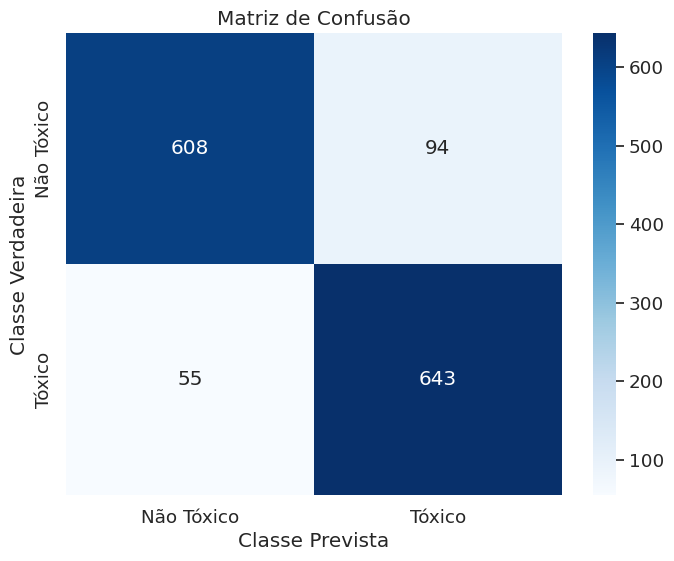

Accuracy: 0.8935714285714286
Precision: 0.8724559023066486
Recall: 0.9212034383954155
F1 Score: 0.8961672473867596


In [ ]:
test_tok = tokenizer(test_hateBR['instagram_comments'].tolist(), return_tensors="tf", padding=True)

test_input_ids = test_tok['input_ids']
test_attention_mask = test_tok['attention_mask']

predictions = model.predict([test_input_ids, test_attention_mask])
predicted_classes = np.argmax(predictions.logits, axis=1)

true_labels = test_hateBR["offensive_language"].values

accuracy = accuracy_score(true_labels, predicted_classes)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_classes, average='binary')

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(true_labels, predicted_classes)
classes = ["Não Tóxico", "Tóxico"]
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


<h3>Teste do modelo utilizando o dataset Brazilian Hatespeech (Twitter)<h3>

178/178 [==============================] - 43s 223ms/step


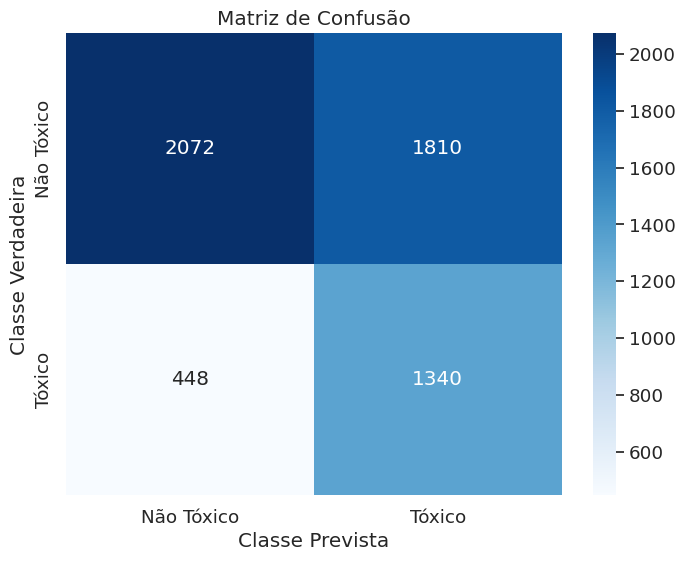

Accuracy: 0.6017636684303351
Precision: 0.4253968253968254
Recall: 0.7494407158836689
F1 Score: 0.5427298501417577


In [ ]:
test_hate_tok = tokenizer(shuffled_hatespeech['text'].tolist(), return_tensors="tf", padding=True)

test_hate_input_id = test_hate_tok['input_ids']
test_hate_attention_mask = test_hate_tok['attention_mask']

predictions_hate = model.predict([test_hate_input_id, test_hate_attention_mask])
predicted_classes_hate = np.argmax(predictions_hate.logits, axis=1)

true_labels_hate = shuffled_hatespeech['hatespeech_comb'].values

accuracy = accuracy_score(true_labels_hate, predicted_classes_hate)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels_hate, predicted_classes_hate, average='binary')

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(true_labels_hate, predicted_classes_hate)
classes = ["Não Tóxico", "Tóxico"]
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

#Implementação dos Modelos BERT Treinado Com o Dataset Brazilian Hatespeech (Twitter)

In [ ]:
# DISITIL
model = TFAutoModelForSequenceClassification.from_pretrained('adalbertojunior/distilbert-portuguese-cased')
tokenizer = AutoTokenizer.from_pretrained('adalbertojunior/distilbert-portuguese-cased', do_lower_case=False)

In [ ]:
#Bertimbau Base
model = TFAutoModelForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased")
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)

In [ ]:
train_tok = tokenizer(train_hatespeech['text'].tolist(), return_tensors="tf", padding=True)
tokenize_data = dict(train_tok)
labels = np.array(train_hatespeech["hatespeech_comb"])

model.compile(optimizer=Adam(3e-5))
model.fit(tokenize_data, labels, epochs=5, batch_size=20) #0,046

Epoch 1/5
227/227 [==============================] - 111s 415ms/step - loss: 0.5054
Epoch 2/5
227/227 [==============================] - 94s 415ms/step - loss: 0.3598
Epoch 3/5
227/227 [==============================] - 94s 415ms/step - loss: 0.2085
Epoch 4/5
227/227 [==============================] - 94s 415ms/step - loss: 0.1185
Epoch 5/5
227/227 [==============================] - 94s 416ms/step - loss: 0.0586


<h3>Teste do modelo utilizando o dataset Brazilian Hatespeech (Twitter)<h3>

36/36 [==============================] - 13s 191ms/step


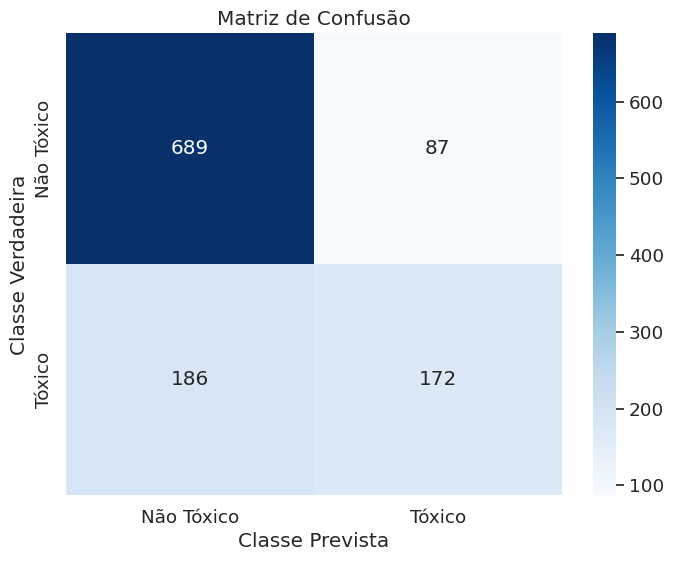

Accuracy: 0.7592592592592593
Precision: 0.6640926640926641
Recall: 0.48044692737430167
F1 Score: 0.5575364667747164


In [ ]:
test_hate_tok = tokenizer(test_hatespeech['text'].tolist(), return_tensors="tf", padding=True)

test_hate_input_id = test_hate_tok['input_ids']
test_hate_attention_mask = test_hate_tok['attention_mask']

predictions_hate = model.predict([test_hate_input_id, test_hate_attention_mask])
predicted_classes_hate = np.argmax(predictions_hate.logits, axis=1)

true_labels_hate = test_hatespeech['hatespeech_comb'].values

accuracy = accuracy_score(true_labels_hate, predicted_classes_hate)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels_hate, predicted_classes_hate, average='binary')

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(true_labels_hate, predicted_classes_hate)
classes = ["Não Tóxico", "Tóxico"]
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

<h3>Teste do modelo utilizando o dataset HateBR (Instagram)<h3>



44/44 [==============================] - 29s 594ms/step


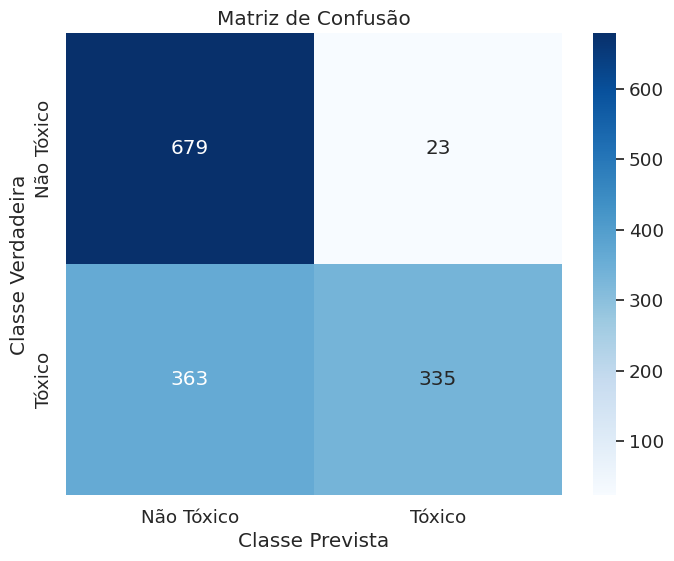

Accuracy: 0.7242857142857143
Precision: 0.9357541899441341
Recall: 0.4799426934097421
F1 Score: 0.634469696969697


In [ ]:
test_tok = tokenizer(test_hateBR['instagram_comments'].tolist(), return_tensors="tf", padding=True)

test_input_ids = test_tok['input_ids']
test_attention_mask = test_tok['attention_mask']

predictions = model.predict([test_input_ids, test_attention_mask])
predicted_classes = np.argmax(predictions.logits, axis=1)

true_labels = test_hateBR["offensive_language"].values

accuracy = accuracy_score(true_labels, predicted_classes)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_classes, average='binary')

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(true_labels, predicted_classes)
classes = ["Não Tóxico", "Tóxico"]
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)